### Tutorial outlines

Tableau provides a variety of [resources](https://public.tableau.com/en-us/s/resources) such as datasets suitable for beginners exploring the software.

This tutorial will walk you through the cleansing of a [dirty dataset](https://en.wikipedia.org/wiki/Dirty_data) collected from Tableau's resources and thus prepare you for doing such on your own in the following exercise. 

# Let's investigate the clean flood dataset, shall we?

In [2]:
import os
from os.path import join
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
file_path = os.path.join(os.getcwd(), 'Cleansed_data\Clean_flood_data.csv')
raw_data = pd.read_csv(file_path)
raw_data.head()

,Country,Began,Ended,Duration in Days,Dead,Displaced,Main cause,Severity *,Affected sq km,Magnitude (M)**,Longitude of Centroid X,Latitude of Centroid Y
0,Columbia,01-Nov-14,14-Dec-14,44,44,0,Heavy rain,1.0,406009.51,7.251989,-75.5440,4.59198
1,USA,11-Dec-14,14-Dec-14,4,3,0,Torrential rain,1.0,50235.67,5.303072,-123.1010,39.79670
2,Brazil,10-Dec-14,14-Dec-14,5,0,0,Torrential rain,1.0,199807.20,5.999581,-49.2145,-24.85130
3,Bulgaria,04-Dec-14,14-Dec-14,11,40,1000,Heavy rain,1.5,147616.57,6.386619,27.7106,41.45790
4,Palestine,26-Nov-14,05-Dec-14,10,0,300,Torrential rain,1.5,2861.66,4.632709,34.4532,31.33780


### Let's check out which country has the most listings and prepare for some analytics

In [4]:
grpby_country = raw_data.groupby('Country')['Country'].count().sort_values(ascending=False)
grpby_country.head(3)

Country
USA      381
China    335
India    219
Name: Country, dtype: int64

### That was USA. Let's have a look at its leading causes for floods

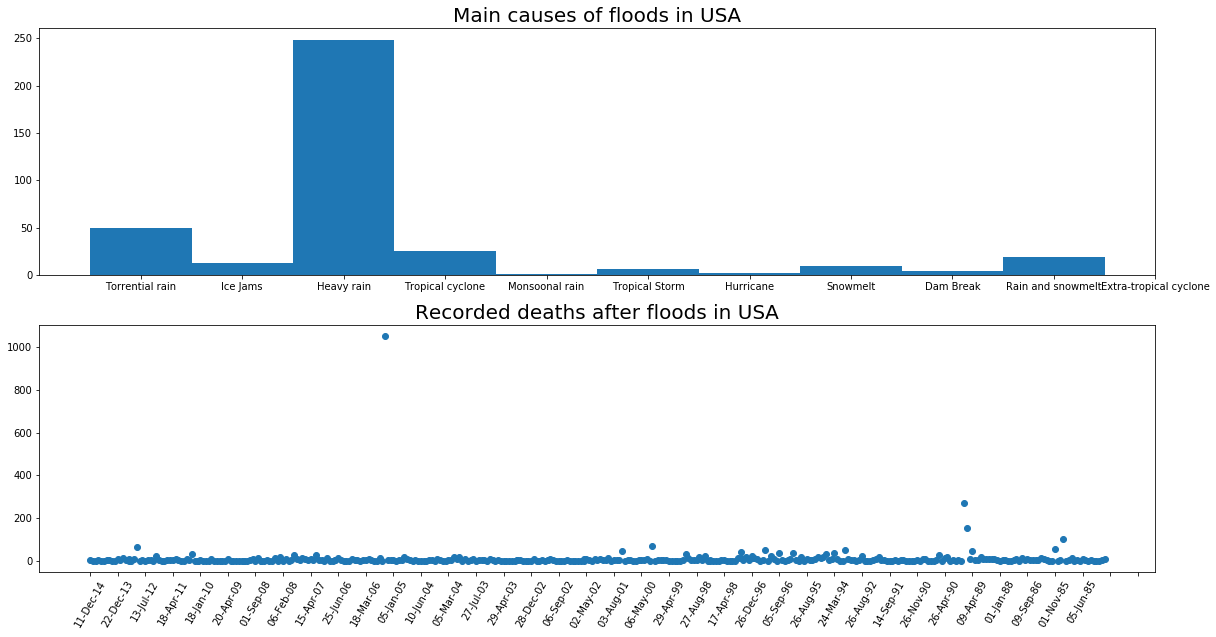

In [5]:
usa_data = raw_data[raw_data['Country'] == 'USA']
fig, ax = plt.subplots(2,1, figsize=(20,10))

ax[0].hist(usa_data['Main cause'], align='left')
ax[0].set_title('Main causes of floods in USA', size=20)

ax[1].scatter(usa_data['Began'], usa_data['Dead'])
ax[1].set_title('Recorded deaths after floods in USA', size=20)

plt.xticks(np.arange(0, len(usa_data), step=10), rotation=60)

plt.show()

## And just for motivation do a quick routine of machine learning!
Say we want to predict the number of deaths following a flood, given information about its duration, number of displaced people and the affected area

In [6]:
usa = usa_data[['Began', 'Duration in Days', 'Dead', 'Displaced', 'Affected sq km']].sample(frac=1, random_state=42)
usa.columns = ['Began', 'Dur', 'Dead', 'Disp', 'Aff']

In [7]:
usa.head()

,Began,Dur,Dead,Disp,Aff
3072,07-Feb-96,7,7,24900,482618.13
2281,17-Mar-02,8,7,2000,40931.32
648,01-Nov-09,3,0,0,14193.55
741,24-Mar-09,28,0,5000,44401.17
756,09-Feb-09,2,0,1000,117999.31


The numbers are extremely varying (Dur << Aff for instance), so we need to do some normalization.

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [9]:
scale = preprocessing.StandardScaler()

X = usa[['Dur', 'Disp', 'Aff']]
y = usa['Dead']

X_scaled = scale.fit_transform(X.values)

y_mean = y.mean()
y_std = y.std()

y_scaled = pd.Series([(yi - y_mean) / y_std for yi in y.values], index=y.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.1, random_state=2)

For this particular problem we'll try the [TheilSenRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TheilSenRegressor.html), a robust multivariate regression model

In [10]:
from sklearn.linear_model import TheilSenRegressor

In [11]:
reg = TheilSenRegressor(random_state=2)
reg.fit(X_train, y_train)

pred = reg.predict(X_test)

y_pred_rescaled = pd.Series([pi*y_std + y_mean for pi in pred], index=y_test.index)
y_test_rescaled = pd.Series([yi*y_std + y_mean for yi in y_test], index=y_test.index)

print(f"Size of train dataset: {len(y_train)}, size of test dataset: {len(y_test)}")

Size of train dataset: 342, size of test dataset: 39


### Obviously we picked a small test dataset, but so is the train dataset.
This demonstration only serves as a proof of concept, and we should ideally be working on thousands of samples.3

Anyway, let's have a look at the results!

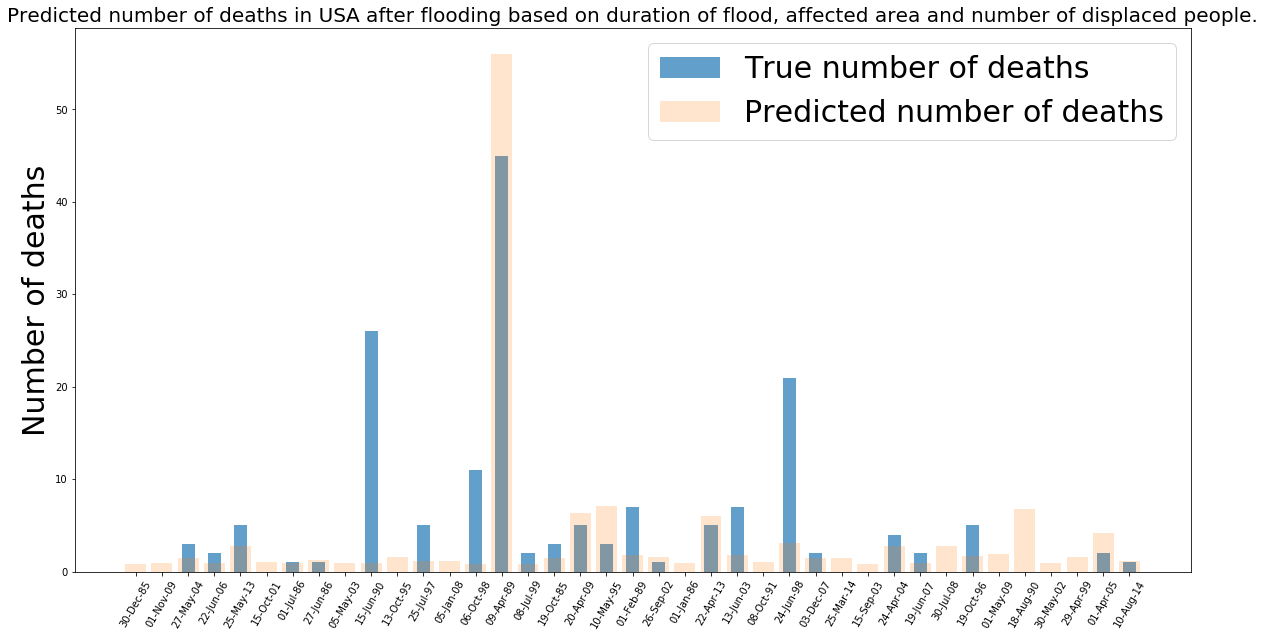

In [12]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
plt.title(f'Predicted number of deaths in USA after flooding based on duration of flood, affected area and number of displaced people.',
         size=20)
dates = [usa.loc[idx]['Began'] for idx in y_test.index]
r = ax.bar(dates, y_test_rescaled, alpha=0.7, width=0.5, label='True number of deaths')
p = ax.bar(dates, y_pred_rescaled, alpha=0.2, label='Predicted number of deaths')
plt.xticks(rotation=60)
plt.ylabel('Number of deaths', size=30)
ax.legend(prop={'size': 30})
plt.show()

### So it's not completely off even though circumstances are suboptimal! Hooray!
Let's investigate the cases where the model failed. What happened 15 Jun 90?

In [13]:
usa_data[usa_data['Began'] == '15-Jun-90']

,Country,Began,Ended,Duration in Days,Dead,Displaced,Main cause,Severity *,Affected sq km,Magnitude (M)**,Longitude of Centroid X,Latitude of Centroid Y
3670,USA,15-Jun-90,16-Jun-90,2,26,440,Torrential rain,1.0,5167.77,4.014333,-80.9321,40.2508


Clearly the duration was very short, and also affected sq km reasonably low. Thus the model (based on only a few hundred samples) expected death rate to be much lower. 
What about the peak 09 Apr 89?

In [14]:
usa_data[usa_data['Began'] == '09-Apr-89']

,Country,Began,Ended,Duration in Days,Dead,Displaced,Main cause,Severity *,Affected sq km,Magnitude (M)**,Longitude of Centroid X,Latitude of Centroid Y
3790,USA,09-Apr-89,19-Apr-89,11,45,306000,Heavy rain,2.0,154568.76,6.531544,-120.672,43.819


Here our model managed to do better since the duration is much longer and affected sq km much larger!

# Congratulations! The data set is clean enough to be analyzed in several ways, which is a topic for you upcoming exercises ;)